# Final project

[Source](https://github.com/octodoge/dssc-num)

In [220]:
import numpy as np

arc = np.load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test = arc['arr_2']
y_test = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


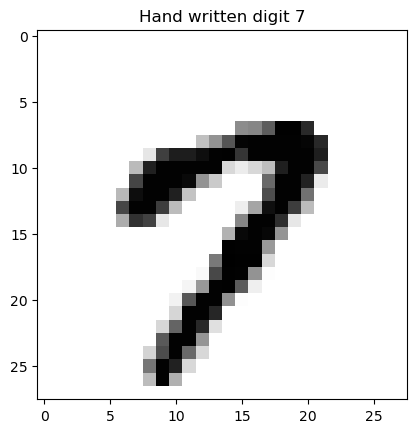

In [2]:
import matplotlib.pyplot as plt

N=15
plt.imshow(x_train[N], cmap='gray_r')
_ = plt.title('Hand written digit '+str(y_train[N]))

General guidelines:
* Time all functions you construct, and try to make them run as fast as possible by precomputing anything that can be precomputed
* Extra points are gained if you reduce the complexity of the given algorithms in any possible way, for example by exploiting linearity, etc.
* If something takes too long to execute, make sure you time it on a smaller set of input data, and give estimates of how long it would take to run the full thing (without actually running it)
* If you don't have enough computational power, run the exercises only up to what is sustainable for your pc

## Assignment 1

Implement the following distance functions

- d_infty $$ d_{\infty}(a,b) := \max_{i,j} |b_{ij}-a_{ij}|$$
- d_one $$ d_1(a,b) := \sum_{i,j} |b_{ij}-a_{ij}|$$
- d_two $$ d_2(a,b) := \sqrt{\sum_{i,j} |b_{ij}-a_{ij}|^2}$$

that take two `(28,28)` images in input, and return a non-negative number.

### Solution

In [3]:
def d_infty(image_a, image_b):
    return np.max(np.abs(image_b - image_a))

def d_one(image_a, image_b):
    return np.sum(np.abs(image_b - image_a))

def d_two(image_a, image_b):
    return np.sqrt(np.sum((image_b - image_a)**2))

#time them
for dist in [d_infty, d_one, d_two]:
    %timeit -n10000 dist(*x_train[:2])

27.2 µs ± 820 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
22.5 µs ± 701 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
30.1 µs ± 2.88 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Assignment 2

Write a function that, given a number `N`, and a distance function `dist`, computes the distance matrix D of shape `(N,N)` between the first `N` entries of `x_train`:

```
D[i,j] = dist(x_train[i], x_train[j])
```

performing the **minimum** number of operations (i.e., avoid computing a distance if it has already been computed before, i.e., keep in mind that dist(a,b) = dist(b,a)).

### Solution

In [4]:
def compute_dist_matrix(N, dist, x_train=x_train):
    D = np.zeros([N, N])
    for i in range(N):
        for j in range(i+1, N):
            D[i,j] = D[j,i] = dist(x_train[i], x_train[j])
    return D

#time it
%timeit -n1000 compute_dist_matrix(5, d_infty)

231 µs ± 28.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Assignment 3

Compute and plot the three distance matrices

- Dinfty
- D1
- D2

for the first 100 images of the training set, using the function `imshow` applied to the three matrices

### Solution

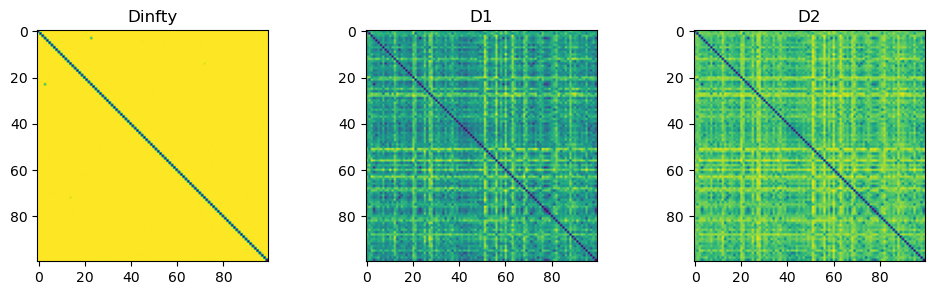

In [5]:
#compute matrices
dist_matrices = {
    'Dinfty': compute_dist_matrix(100, d_infty),
    'D1': compute_dist_matrix(100, d_one),
    'D2': compute_dist_matrix(100, d_two)}

#plot
_, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, (name, D) in zip(axes, dist_matrices.items()):
    ax.imshow(D)
    ax.set_title(name)

## Assignment 4

Using only a distance matrix, apply the algorithm described above and compute the efficency of the algorithm, i.e., write a function that:

Given a distance matrix with shape `(N,N)`, constructed on the first `N` samples of the `x_train` set, count the number of failures of the **leave one out** strategy, i.e., 

- set `error_counter` to zero

- for every line `i` of the matrix:

    - find the index `j` (different from `i`) for which `D[i,k] >= D[i,j]` for all `k` different from `i` and `j`.

    - if `y_train[j]` is different from `y_train[i]`, increment by one `error_counter`

- return the error: error_counter/N

- apply the function above to the 3 different distance matrices you computed before

### Solution

In [6]:
def compute_efficiency(D):
    error_counter = 0            
    for i in range(len(D)):

        #classify
        D[i,i] = np.inf
        digit = y_train[np.argmin(D[i])]
        D[i,i] = 0

        error_counter += digit != y_train[i]
    return error_counter/len(D)

#time it
%timeit -n1000 compute_efficiency(dist_matrices['Dinfty'])

818 µs ± 62.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Assignment 5

Run the algorithm implemented above for N=100,200,400,800,1600 on the three different distances, and plot the three error rate as a function of N (i.e., compute the distance matrix, and compute the efficiency associated to the distance matrix).

You should get an error like:
```
[[ 0.58      0.17      0.17    ]
 [ 0.52      0.145     0.135   ]
 [ 0.4425    0.15      0.135   ]
 [ 0.4       0.145     0.12875 ]
 [ 0.369375  0.1025    0.09375 ]]
```
where each column represents a different norm.

** In the next assignments, optional points are given if you manage to make the algorithm run faster, by pre-computing everything you can precompute in advance **

### Solution

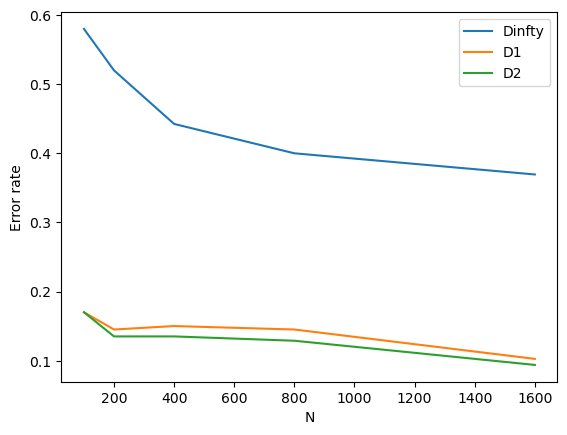

In [7]:
#compute matrices
max_N = 1600
max_dist_matrices = {
    'Dinfty': compute_dist_matrix(max_N, d_infty),
    'D1': compute_dist_matrix(max_N, d_one), 
    'D2': compute_dist_matrix(max_N, d_two)}
dist_matrices = {name: {N: D[:N,:N] for N in [100, 200, 400, 800, 1600]} for name, D in max_dist_matrices.items()}

#compute efficiencies
efficiencies = {name: {N: compute_efficiency(D) for N,D in matrices.items()} for name, matrices in dist_matrices.items()}

#plot
for name, errors in efficiencies.items():
    plt.plot(errors.keys(), errors.values(), label=name)
plt.xlabel('N')
plt.ylabel('Error rate')
_ = plt.legend()

# Assignment 6

In principle, it should be possible to decrease the error by using a better norm. From the table above, it is clear that the L2 distance works better than the L1 distance, which works better than the Linfty distance.

However, *none of these distances exploit the fact that the image is a two-dimensional object*, and that there is information also in the **neighboring** information of the pixels. 

One way to exploit this, is to interpret the image as a continuous function with values between zero and one, defined on a square domain `\Omega=[0,27]x[0,27]`.

$$ f: \Omega \to R $$

- Implement a function that computes an approximation of the $H^1$ norm distance on the renormalized images. Given two images $f_1$ and $f_2$
    - Compute $$a = \frac{f_1}{\int_\Omega f_1}$$, $$b=\frac{f_2}{\int_\Omega f_2}$$
    - Define the $H^1$ distance as
    $$
    d_{H^1}(f_1,f_2) := \sqrt{\int_\Omega |\nabla(a-b)|^2+ (a-b)^2}
    $$
    using the algorithm you prefer (or the library you prefer) to compute the gradients and the integrals. Notice that $\nabla f = (\partial f/\partial x, \partial f/\partial y)$ is a vector valued function, and $|\nabla g|^2 := (\partial g/\partial x)^2 + (\partial g/\partial y)^2$

- Compute the distance matrix and the efficiency for this distance for N=100,200,400,800,1600

### Solution

In [39]:
from scipy.integrate import simpson

def integrate(image):
    return simpson(simpson(image))

#precompute renormalized images
x_train_renorm = x_train[:6400]/integrate(x_train[:6400]).reshape(6400, 1, 1) #6400 for assignment 7

def d_H(image_a_renorm, image_b_renorm):
    g = (image_a_renorm - image_b_renorm).reshape(28, 28) #unflat for assignment 7
    partial_x, partial_y = np.gradient(g)
    return np.sqrt(integrate(partial_x**2 + partial_y**2 + g**2))

#time it
%timeit -n1000 d_H(*x_train_renorm[:2])

406 µs ± 1.16 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
#compute matrices
max_dist_matrices['DH'] = compute_dist_matrix(max_N, d_H, x_train=x_train_renorm)
dist_matrices['DH'] = {N: max_dist_matrices['DH'][:N,:N] for N in [100, 200, 400, 800, 1600]}

#compute efficiencies
efficiencies['DH'] = {N: compute_efficiency(D) for N,D in dist_matrices['DH'].items()}
efficiencies

{'Dinfty': {100: 0.58, 200: 0.52, 400: 0.4425, 800: 0.4, 1600: 0.369375},
 'D1': {100: 0.17, 200: 0.145, 400: 0.15, 800: 0.145, 1600: 0.1025},
 'D2': {100: 0.17, 200: 0.135, 400: 0.135, 800: 0.12875, 1600: 0.09375},
 'DH': {100: 0.22, 200: 0.175, 400: 0.1375, 800: 0.11875, 1600: 0.09625}}

## Assigment 7

Use the `BallTree` algorithm (https://en.wikipedia.org/wiki/Ball_tree), from the `sklearn` package, and construct a tree data structure **that uses a distance from the steps defined above**.

For N in `[3200, 6400]` and for each distance defined above

- Build a tree using the first N entries of the training set `x_train`
- Construct a function that tests the efficiency on all the entries of the test set `x_test`:
    - for any image in `x_test`, call it `x_test[i]`, query the tree for the nearest neighbor (call it `k`), and assign as predicted digit the digit of the `x_train[k]` image, i.e., `y_train[k]`
    - check if `y_train[k]` is equal to the corresponding entry in `y_test[i]`. If not, increment a counter of the error
    - return the efficiency, i.e., `error_counter/len(x_test)`
- Plot, in a single graph, the error of each distance as a function of `N` (including labels, titles, etc.)

- Once you have the tree, experiment with different nearest neighbor algorithms, i.e., instead of taking only one nearest neighbor, take a larger number (a small number of your choice), and instead of returning the single closest digit, return the one with the largest number of occurrences. Plot the same graph you gave before, and see if you gain an improvement. Motivate all choices you have to make to get to the final answer.

### Solution

In [96]:
from sklearn.neighbors import BallTree

def get_tree(name, x_train):
    x_train_flat = x_train.reshape(len(x_train), 784)
    return BallTree(x_train_flat, metric='pyfunc', func=eval(name))

#build trees
trees = {name: {N: get_tree(name, x_train[:N]) for N in [3200, 6400]} for name in ['d_infty', 'd_one', 'd_two']}
trees['d_H'] = {N: get_tree('d_H', x_train_renorm[:N]) for N in [3200, 6400]}
trees

In [226]:
#precompute renormalized images
x_test_renorm = x_test/integrate(x_test).reshape(len(x_test), 1, 1)

def test_efficiency(tree, n_samples=100): #n_samples for slow hardware
    X = x_test_renorm[:n_samples] if tree in trees['d_H'].values() else x_test[:n_samples]
    _, k = tree.query(X.reshape(n_samples, 784))
    error_counter = np.sum(y_train[k.reshape(n_samples)] != y_test[:n_samples])
    return error_counter/n_samples

#time it
%timeit -n1 test_efficiency(trees['d_infty'][3200]) #would take len(x_test)/n_samples longer on all samples

6.47 s ± 190 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


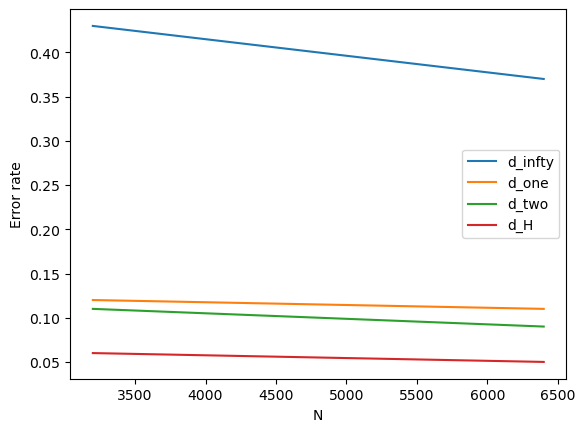

In [228]:
#compute efficiencies
efficiencies = {name: {N: test_efficiency(tree) for N, tree in trees_.items()} for name, trees_ in trees.items()}

#plot
for name, errors in efficiencies.items():
    plt.plot(errors.keys(), errors.values(), label=name)
plt.xlabel('N')
plt.ylabel('Error rate')
_ = plt.legend()

In [ ]:
#TODO